In [16]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
%cd /gdrive/My Drive/

/gdrive/My Drive


In [18]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [19]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [20]:
#!unzip training_dataset_homework2

In [21]:
x_train=np.load('x_train.npy')
y_train=np.load('y_train.npy')

In [22]:
x_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [23]:
labels_mapping={ "Wish":0, "Another":1, "Comfortably" :2, "Money":3, "Breathe":4,"Time":5,"Brain":6,"Echoes":7, "Wearing":8,"Sorrow":9,"Hey":10,"Shine":11}


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2186, 36, 6), (243, 36, 6), (2186,), (243,))

In [31]:
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2186, 36, 6), (2186, 12), (243, 36, 6), (243, 12))

In [47]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [32]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

In [33]:
window = 200
stride = 50

In [34]:
def build_sequences(df, window=200, stride=200):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for id in df['id'].unique():
        # Take only meaningful features
        temp = df[df['id'] == id][['x_axis','y_axis','z_axis']].values
        # Save the label
        label = df[df['id'] == id]['activity'].values[0]
        # Compute padding length
        padding_len = window - len(temp)%window
        # Create padding and concatenate it
        padding = np.zeros((padding_len,3), dtype='float64')
        temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [35]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [36]:
model = build_LSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 36, 128)           69120     
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 12)                1548      
                                                                 
Total params: 218,764
Trainable params: 218,764
Non-trainable

In [37]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
16/16 [==============================] - 9s 92ms/step - loss: 2.1396 - accuracy: 0.3401 - val_loss: 1.7496 - val_accuracy: 0.4384 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 19ms/step - loss: 1.7008 - accuracy: 0.4413 - val_loss: 1.4480 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 19ms/step - loss: 1.4369 - accuracy: 0.4972 - val_loss: 1.2437 - val_accuracy: 0.5708 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 1.2862 - accuracy: 0.5582 - val_loss: 1.1543 - val_accuracy: 0.5982 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: 1.1656 - accuracy: 0.5958 - val_loss: 1.0855 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 0s 17ms/step - loss: 1.0549 - accuracy: 0.6360 - val_loss: 1.0265 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 0s 19ms/step - lo

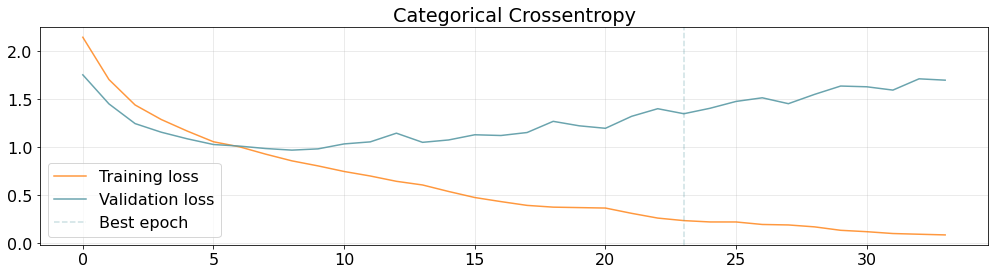

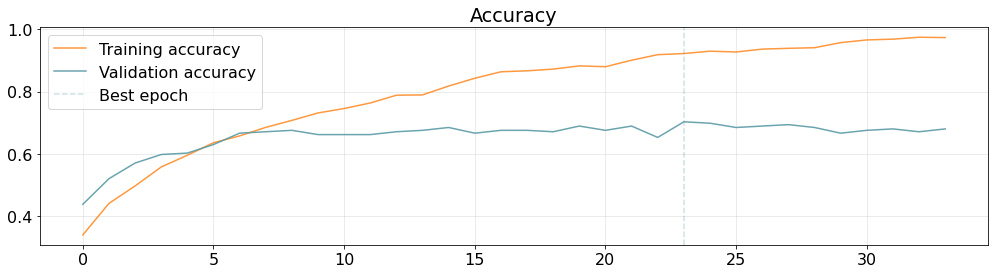

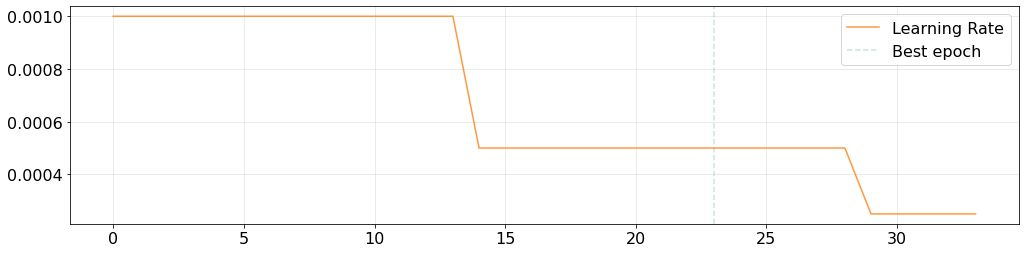

In [38]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [39]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [40]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 36, 256)          138240    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 12)                1548  

In [41]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
16/16 [==============================] - 7s 109ms/step - loss: 2.0259 - accuracy: 0.3538 - val_loss: 1.5498 - val_accuracy: 0.5068 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 18ms/step - loss: 1.5229 - accuracy: 0.4789 - val_loss: 1.2375 - val_accuracy: 0.5708 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 18ms/step - loss: 1.2600 - accuracy: 0.5618 - val_loss: 1.1142 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 19ms/step - loss: 1.0845 - accuracy: 0.6157 - val_loss: 1.0517 - val_accuracy: 0.6256 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 18ms/step - loss: 0.9653 - accuracy: 0.6690 - val_loss: 0.9796 - val_accuracy: 0.6621 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 0s 18ms/step - loss: 0.8455 - accuracy: 0.7026 - val_loss: 0.9897 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 0s 19ms/step - l

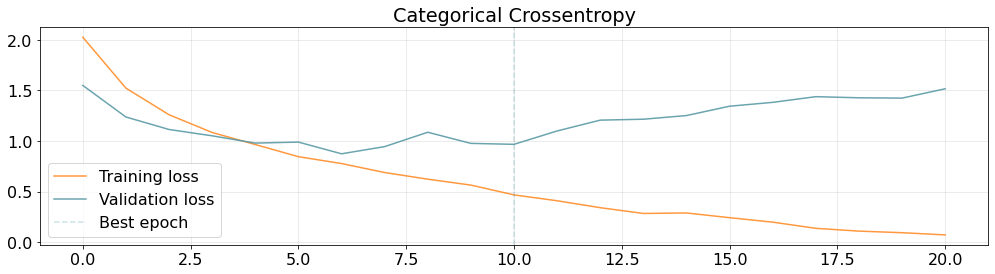

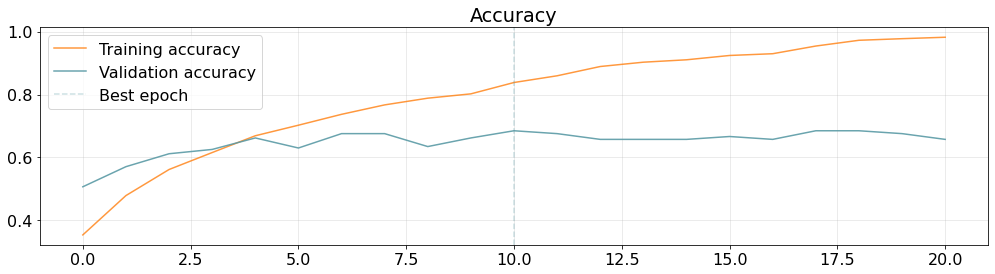

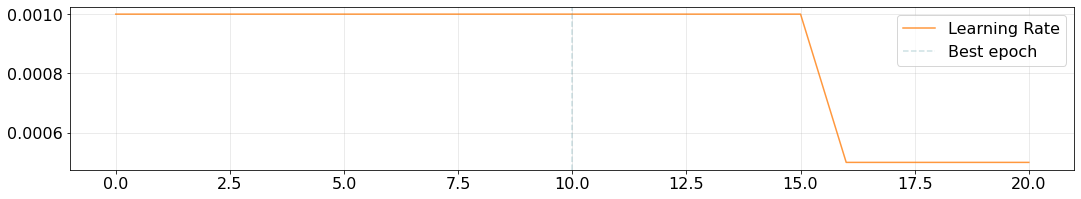

In [42]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [43]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [44]:
model = build_1DCNN_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           2432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 128)               0     

In [45]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
16/16 [==============================] - 5s 26ms/step - loss: 19.2693 - accuracy: 0.0824 - val_loss: 6.0692 - val_accuracy: 0.1142 - lr: 0.0010
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 6.8620 - accuracy: 0.1612 - val_loss: 3.2655 - val_accuracy: 0.2009 - lr: 0.0010
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 4.4628 - accuracy: 0.2008 - val_loss: 3.0094 - val_accuracy: 0.2557 - lr: 0.0010
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 3.2470 - accuracy: 0.2949 - val_loss: 2.4554 - val_accuracy: 0.3790 - lr: 0.0010
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 2.8687 - accuracy: 0.3157 - val_loss: 2.2095 - val_accuracy: 0.4429 - lr: 0.0010
Epoch 6/200
16/16 [==============================] - 0s 6ms/step - loss: 2.6476 - accuracy: 0.3798 - val_loss: 1.9793 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 7/200
16/16 [==============================] - 0s 6ms/step - loss: 2